In [1]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [3]:
dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
1181,2821,1420000169943_1.jpg,Viscose,Shalwar Kameez,"red,brown,golden","embroidery,printed",NaN
2203,7362,0570000116401_1.jpg,Cotton,Panjabi,"grey,black",textured,NaN
2715,7432,0410000096032_3.jpg,Viscose,Tops,"orange,pink,blue","dobby,tie dye",NaN


In [4]:
single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']

Repeating the preprcessing steps to remove NaN values and removing rare labels (details explained in previous notebook)

In [5]:
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean
1309,7860,0460000029937_1.jpg,Cotton,Nightwear,"blue,cyan",printed,lace
3240,7662,0470000103625.jpg,Silk,Scarves,"grey,black,green",hand paint,
1770,7840,0460000029972.jpg,Voile,Nightwear,"blue,white","embroidery,printed",


Encode the labels as done previously

In [6]:
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)

df.sample(3)

,product_id,annotated_image_name,fabric_types_clean,wear_types_clean,colors_clean,textures_clean,value_additions_clean,fabric_types_clean__Cotton,fabric_types_clean__Linen,fabric_types_clean__Muslin,...,textures_clean__wax dye,value_additions_clean__,value_additions_clean__applique,value_additions_clean__fringe,value_additions_clean__handloom,value_additions_clean__lace,value_additions_clean__nakshi,value_additions_clean__sequins,value_additions_clean__tangail,value_additions_clean__tassels
614,1656,0540000023497_1.jpg___dress.png,Silk,Saree,"black,white,green","dye,embroidery,printed",,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2817,3029,0430000116016_2.jpg___dress.png,Muslin,Shalwar Kameez,"yellow,cyan,white","embroidery,printed",,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0
873,2013,0540000024729_2.jpg,Silk,Saree,"black,grey,yellow",,tangail,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# Train/Val/Test Split in 70/15/15 ratio

from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)

In [8]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
from my_utils.CustomDataset import CustomMTLDataset
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

---

This time, let's try an EfficientNet model, and few additional layers on top of it. This is unlike the previous experiment where just one layer classification head was used.

Also I'll be adding a param to enable/disable base model training (by freezing the base model layers), leaving room to experiment with feature extraction instead of fine-tuning.

In [10]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def generate_custom_head(shared_dim, output_dim):
	return nn.Sequential(
		nn.Linear(shared_dim, 256),
		nn.ReLU(),
		nn.Dropout(0.3),
		nn.Linear(256, output_dim)
	)

class MTLModelEfficientNet(nn.Module):
	def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim, freeze_backbone=False):
		super(MTLModelEfficientNet, self).__init__()
		self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

		if freeze_backbone:
			for param in self.backbone.parameters():
				param.requires_grad = False

		# Remove the classifier head
		self.backbone.classifier = nn.Identity()
		self.shared_dim = 1280  				# Output of EfficientNet-B0's second last layer

		self.heads = nn.ModuleDict({
			'fabric': generate_custom_head(self.shared_dim, fabric_dim),
			'wear': generate_custom_head(self.shared_dim, wear_dim),
			'color': generate_custom_head(self.shared_dim, color_dim),
			'texture': generate_custom_head(self.shared_dim, texture_dim),
			'value_add': generate_custom_head(self.shared_dim, value_add_dim),
		})

	def forward(self, x):
		features = self.backbone(x)
		return {task: head(features) for task, head in self.heads.items()}

This time I modify the loss function to consider class weights when calculating BCE. This may help with the class imbalance.

In [11]:
def calc_class_weights(dataloader, tasks):
    total_counts = {task: {'pos': None, 'neg': None} for task in tasks}
    
    for _, labels in dataloader:
        for task in tasks:
            # contains (batch_size, num_labels)
            label_tensor = labels[task]
            if total_counts[task]['pos'] is None:
                total_counts[task]['pos'] = label_tensor.sum(dim=0)
                total_counts[task]['neg'] = (1 - label_tensor).sum(dim=0)
            else:
                total_counts[task]['pos'] += label_tensor.sum(dim=0)
                total_counts[task]['neg'] += (1 - label_tensor).sum(dim=0)

    class_weights = {}
    for task in tasks:
        pos = total_counts[task]['pos']
        neg = total_counts[task]['neg']
        weight = neg / (pos + 1e-5)  # avoiding div by zero
        class_weights[task] = weight

	# returns Dict[str, Tensor] representing class weights for each task
    return class_weights

Note that, in addition to the weighted loss, I will also calculate unweighted loss during the epoch. Weighted loss will still be used for backpropagation, but unweighted loss can be used to compare the performance against validation set. This is because using weighted loss will make it difficult to compare against validation loss, as they turn out to be in different ranges.

In [ ]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import json

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5, class_weights=None):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	total_unweighted_loss = 0.0

	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []
			unweighted_losses = []

			for task in outputs:
				unweighted_loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])

				if class_weights and task in class_weights:
					weights = class_weights[task].to(device)	#TODO:: Check if need to unsqueeze
					loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task], weight=weights)
				else:
					loss = unweighted_loss
					
				losses.append(loss)
				unweighted_losses.append(unweighted_loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			total_unweighted_loss += (sum(unweighted_losses)).item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)
	avg_unweighted_loss = total_unweighted_loss / len(loader)

	if not is_train:
		metrics = {
			task: {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task])
			}
			for task in all_preds
		}
		return avg_loss, metrics
	else:
		return avg_loss, avg_unweighted_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, use_class_weights=False, verbose=True):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	timestamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
	best_model_path = os.path.join('../data', 'model_weights', f'best_model-efficientnet-{timestamp}.pt')
	history_path = os.path.join('../data', 'model_weights', f'history-efficientnet-{timestamp}.json')

	history = {
		'train_loss': [],
		'unweighted_train_loss': [],
		'val_loss': [],
		'val_metrics': []
	}

	class_weights = calc_class_weights(train_loader, model.heads.keys()) if use_class_weights else None

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss, unweighted_train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True, class_weights=class_weights)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['unweighted_train_loss'].append(unweighted_train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), best_model_path)
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")
				break

	# Save the training history
	with open(history_path, 'w') as f:
		json.dump(history, f)
		
	return history


In [13]:
model = MTLModelEfficientNet(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
	freeze_backbone=False
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [14]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	use_class_weights=True,
	verbose=False
)



Epoch 1/10


100%|██████████| 62/62 [00:04<00:00, 13.89it/s]


Train Loss: 15.6538
Val Loss: 1.2938

Epoch 2/10


100%|██████████| 62/62 [00:03<00:00, 16.77it/s]


Train Loss: 12.3227
Val Loss: 1.2425

Epoch 3/10


100%|██████████| 62/62 [00:03<00:00, 16.94it/s]


Train Loss: 11.4721
Val Loss: 1.1626

Epoch 4/10


100%|██████████| 62/62 [00:03<00:00, 17.17it/s]


Train Loss: 10.9625
Val Loss: 1.1686

Epoch 5/10


100%|██████████| 62/62 [00:03<00:00, 17.22it/s]


Train Loss: 10.2312
Val Loss: 1.1762

Epoch 6/10


100%|██████████| 62/62 [00:03<00:00, 16.86it/s]


Train Loss: 9.7592
Val Loss: 1.1294

Epoch 7/10


100%|██████████| 62/62 [00:03<00:00, 16.39it/s]


Train Loss: 9.2005
Val Loss: 1.1683

Epoch 8/10


100%|██████████| 62/62 [00:06<00:00,  9.80it/s]


Train Loss: 8.6084
Val Loss: 1.0829

Epoch 9/10


100%|██████████| 62/62 [00:03<00:00, 17.15it/s]


Train Loss: 8.2527
Val Loss: 1.1183

Epoch 10/10


100%|██████████| 62/62 [00:03<00:00, 16.68it/s]

Train Loss: 7.6900
Val Loss: 1.1512


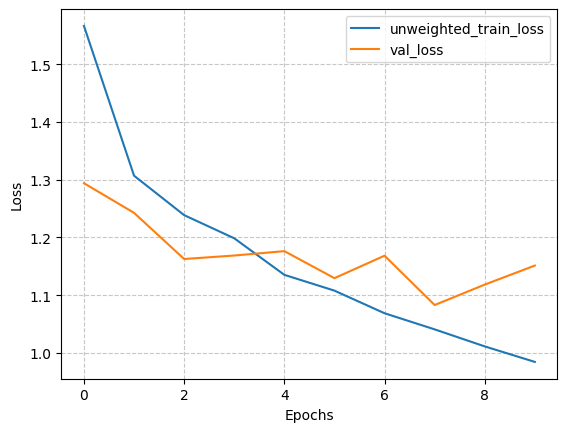

In [15]:
import matplotlib.pyplot as plt

from my_utils.plot_utils import plot_train_val_loss

plot_train_val_loss(history)

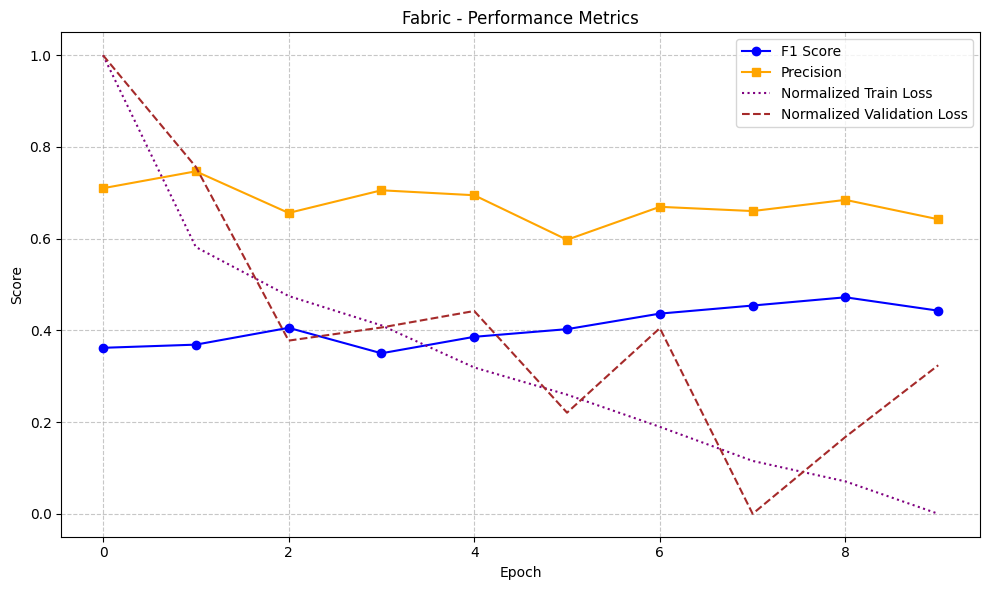

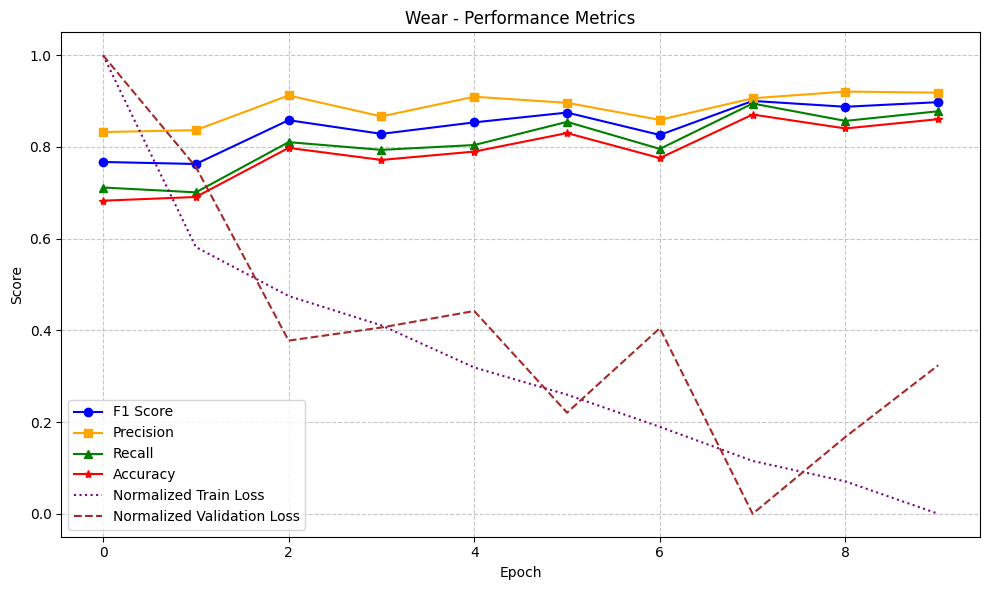

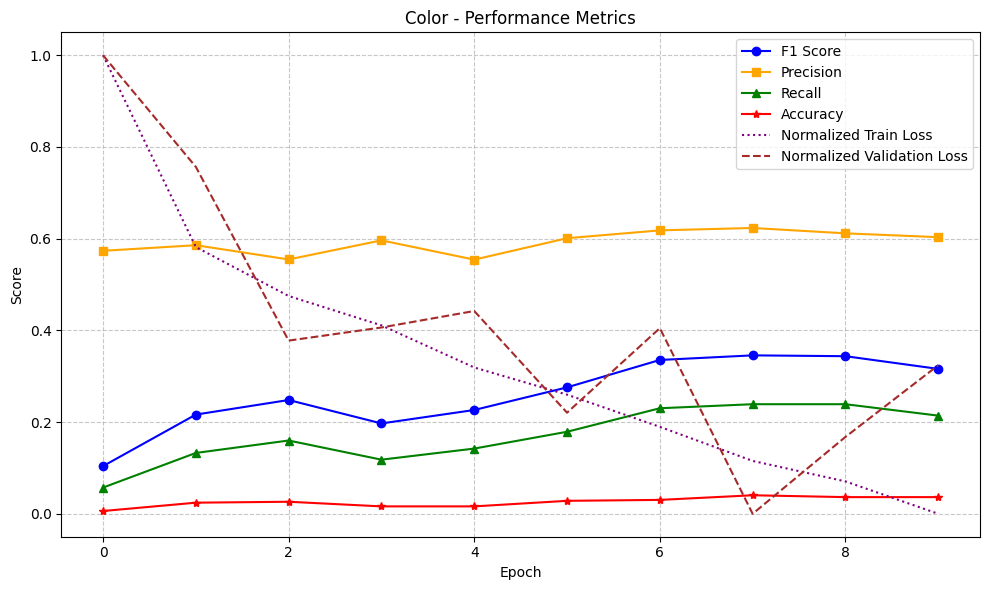

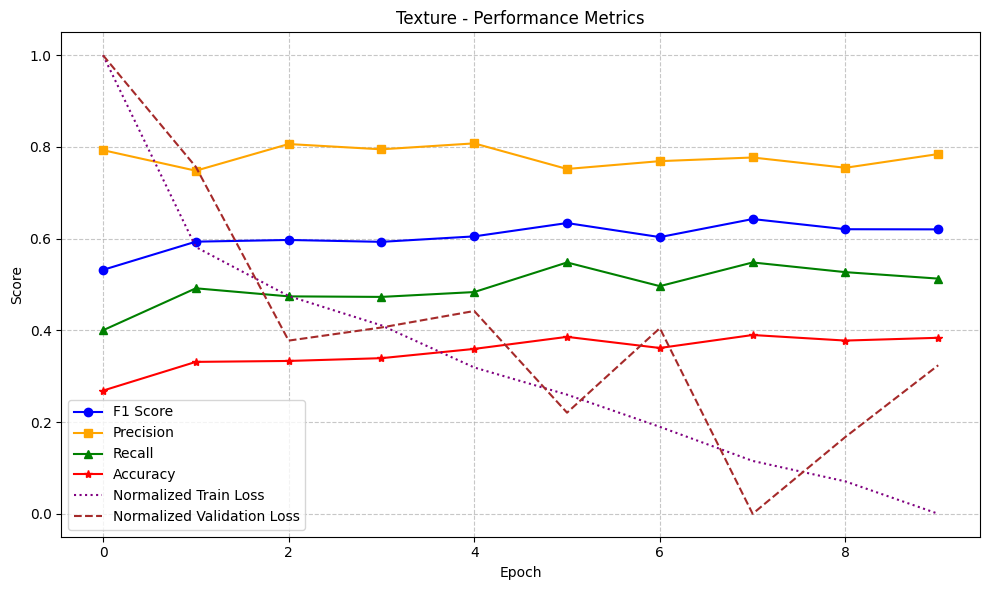

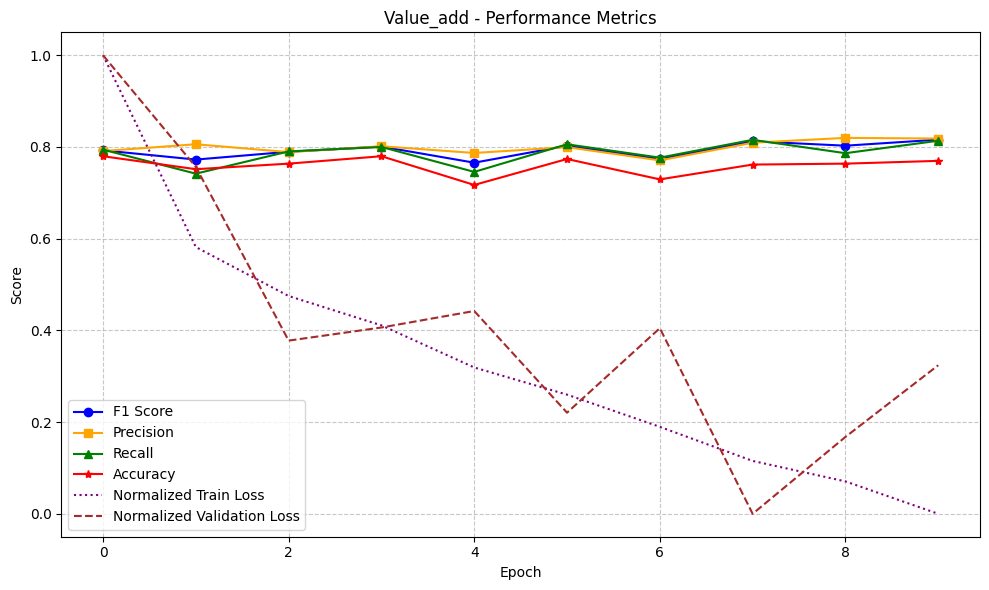

In [16]:
from my_utils.plot_utils import plot_metrics_for_task

plot_metrics_for_task(history, 'fabric', ['f1', 'precision'], show_losses=True)
plot_metrics_for_task(history, 'wear', show_losses=True)
plot_metrics_for_task(history, 'color', show_losses=True)
plot_metrics_for_task(history, 'texture', show_losses=True)
plot_metrics_for_task(history, 'value_add', show_losses=True)

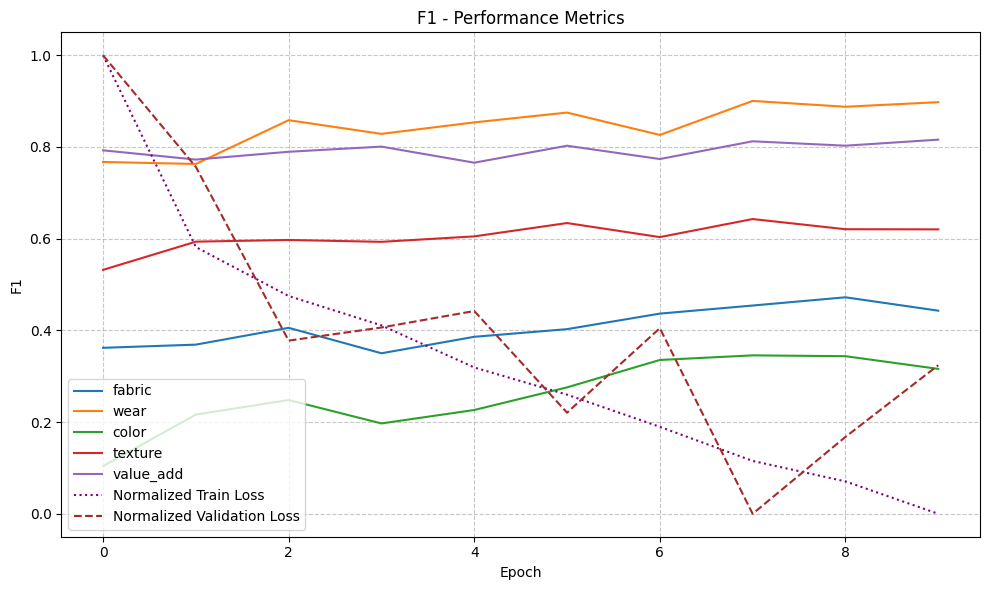

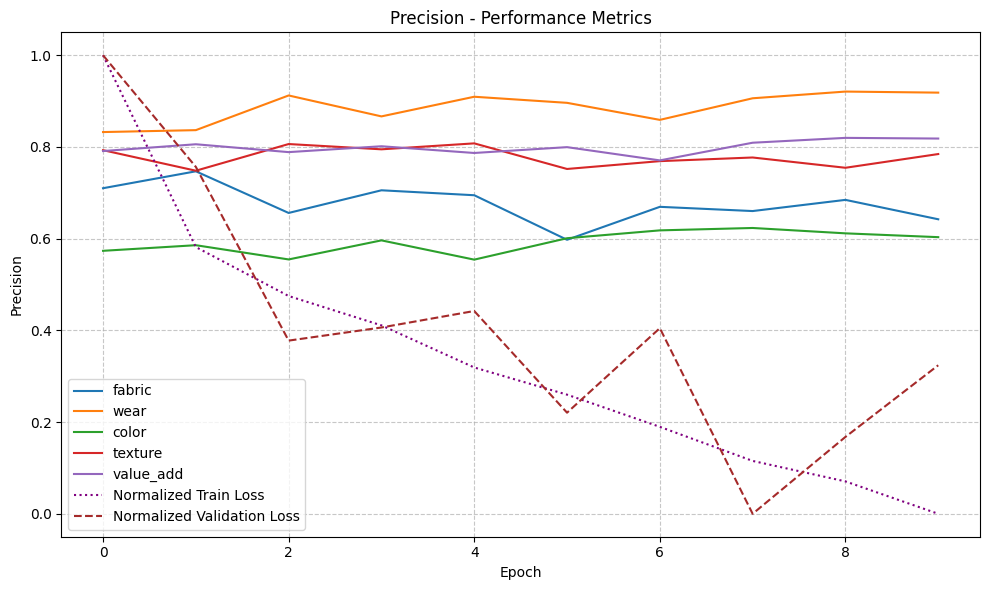

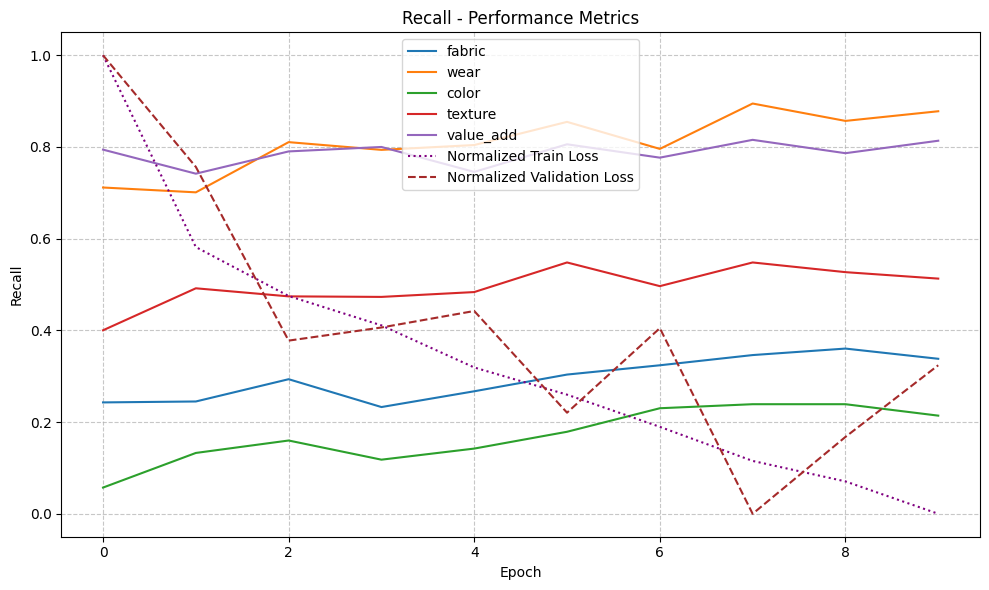

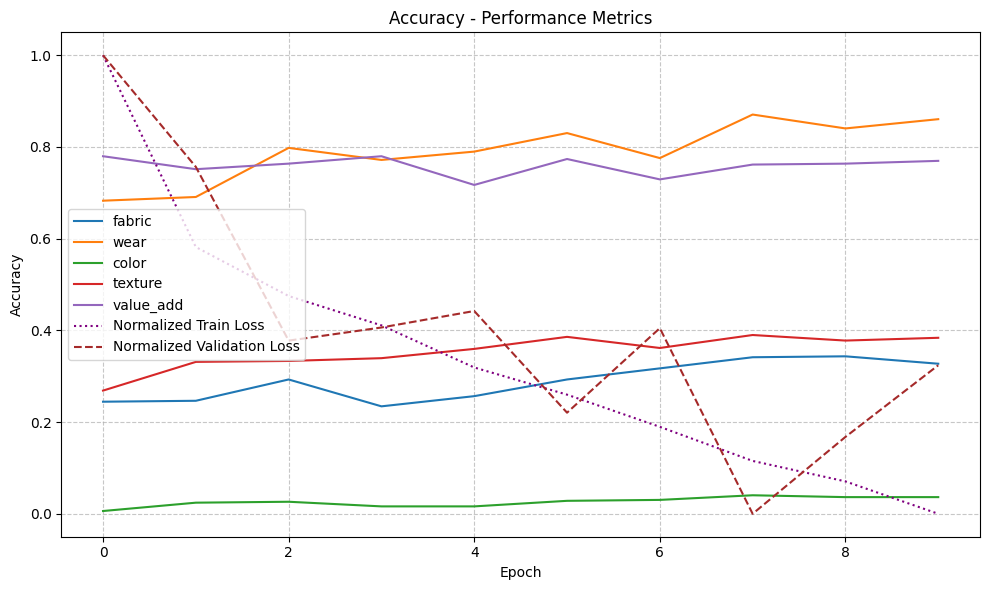

In [17]:
from my_utils.plot_utils import compare_tasks_for_metric

compare_tasks_for_metric(history, 'f1', show_losses=True)
compare_tasks_for_metric(history, 'precision', show_losses=True)
compare_tasks_for_metric(history, 'recall', show_losses=True)
compare_tasks_for_metric(history, 'accuracy', show_losses=True)